In [103]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
import numpy as np

#### We start by importing the bloodtypes csv file, and taking a look to make sure the data is formatted correctly. 

In [104]:
bloodtypes_df=pd.read_csv("bloodtypes.csv")
#make sure the countries are alphabetized
bloodtypes_df.sort_values("Country", inplace=True, ascending=True)
bloodtypes_df.head()

,Country,Population,O+,A+,B+,AB+,O-,A-,B-,AB-
121,Venezuela,28644603,58.30,28.20,5.60,1.90,3.70,1.80,0.40,0.10
122,Vietnam,98721275,41.70,21.90,30.80,4.98,0.30,0.10,0.20,0.02
125,World,7772850805,37.37,27.24,22.83,6.22,2.69,2.09,1.16,0.40
123,Yemen,29884405,47.84,27.50,15.32,2.14,3.66,2.10,1.17,0.16
124,Zimbabwe,14546314,63.30,18.50,14.60,0.99,1.70,0.50,0.40,0.01


#### Our bloodtypes dataframe only has bloodtypes and countries, but I'd like to include region and sub-regions of the world for a more granular view of of what's going on. We'll merge it with a dataframe that includes these datapoints for each country represented

In [105]:
continents_df=pd.read_csv("continents2.csv")

In [107]:
continents_df.sort_values("name", inplace=True, ascending=True)
#I'm dropping all columns that we don't need, and also changing some of the columns 
#to match our bloodtypes dataframe's naming conventions
continents_df.rename(columns={"name":"country","sub-region":"sub_region"})
regions=continents_df.drop(["alpha-2","alpha-3","country-code","iso_3166-2","intermediate-region",
                            "region-code","sub-region-code","intermediate-region-code"],axis=1)

#### Next, we're going to cut down our dataset to isolate the countries listed in bloodtypes considering that the regions is 249 rows long, whereas bloodtypes is only 126. We'll use a set object to isolate the intersection between these datasets.  

In [108]:
shortlist=bloodtypes_df["Country"]
set_a=set(shortlist)
set_b=set(regions["name"])
common=set_a.intersection(set_b)
common_countries=pd.DataFrame(list(common))
common_countries.columns = ['country']
common_countries.sort_values('country', ascending=True, inplace=True)

In [109]:
region_column=[]
sub_column=[]

#Take each country from the common_countries set, and save the associated region and sub-region from the regions df.     
for i in common_countries["country"]:
    k=regions[regions['name']==i]
    region_column.append(*k[['region']].values)
    sub_column.append(*k[['sub-region']].values)

#We then unpack the arrays created in the loop above, saving them to an unzipped list, and then converting the regions
#and sub-regions columns into dataframes.
region_column=[*list(zip(*region_column))[0]]
sub_column=[*list(zip(*sub_column))[0]]
region_column_df = pd.DataFrame(region_column, columns=['region'])
subregion_column_df = pd.DataFrame(sub_column, columns=['sub-region'])

In [110]:
#In this cell we're going to continue assembling our columns, before creating our complete dataframe in the next cell
b_types_holder=[]
population=[]
for i in bloodtypes_df["Country"]:
    for j in common_countries["country"]:
        if i==j:
            index=bloodtypes_df.index[bloodtypes_df['Country']==i].tolist()
            b_types_holder.append(bloodtypes_df.iloc[index,:])
            population.append(*bloodtypes_df.iloc[index,1].values)

In [113]:
#First we'll initialize the first row of the complete dataframe, then iteratively assemble complete_df
complete_df=pd.DataFrame(b_types_holder[0],columns=b_types_holder[0].columns)
for i in range(1,len(b_types_holder)):
    complete_df=pd.concat([complete_df, b_types_holder[i]], ignore_index=True)
complete_df['region']=region_column_df
complete_df['sub-region']=subregion_column_df
complete_df = complete_df[['Country', 'region','sub-region',"Population","O+","A+","B+","AB+",'O-',"A-",'B-','AB-']]
complete_df=complete_df.rename(columns={"region":"Region", 'sub-region':"Sub_Region"})

#### Before we do any data manipulation to our columns, we need to check if there are any missing values (NaN) for any of them so our calculations work.

In [114]:
print(complete_df.isna().sum().sort_values())

Country       0
Region        0
Sub_Region    0
Population    0
O+            0
A+            0
B+            0
AB+           0
O-            1
A-            1
B-            1
AB-           1
dtype: int64


#### It looks like we have some missing datapoints in our bloodtypes columns, so I'll use imputation to set these values equal to zero instead and check again to make sure the changes were logged in complete_df

In [115]:
complete_df=complete_df.fillna(0)
print(complete_df.isna().sum().sort_values())

Country       0
Region        0
Sub_Region    0
Population    0
O+            0
A+            0
B+            0
AB+           0
O-            0
A-            0
B-            0
AB-           0
dtype: int64


#### Lastly, before moving on, we need to convert our bloodtype percentages to actual population figure for each country.

In [116]:
complete_df['O+_val']=complete_df['O+']*complete_df['Population']/100
complete_df['O+_val']=complete_df['O+_val'].apply(math.floor)

complete_df['A+_val']=complete_df['A+']*complete_df['Population']/100
complete_df['A+_val']=complete_df['A+_val'].apply(math.floor)

complete_df['B+_val']=complete_df['B+']*complete_df['Population']/100
complete_df['B+_val']=complete_df['B+_val'].apply(math.floor)

complete_df['AB+_val']=complete_df['AB+']*complete_df['Population']/100
complete_df['AB+_val']=complete_df['AB+_val'].apply(math.floor)

complete_df['O-val']=complete_df['O-']*complete_df['Population']/100
complete_df['O-val']=complete_df['O-val'].apply(math.floor)

complete_df['A-_val']=complete_df['A-']*complete_df['Population']/100
complete_df['A-_val']=complete_df['A-_val'].apply(math.floor)

complete_df['B-val']=complete_df['B-']*complete_df['Population']/100
complete_df['B-val']=complete_df['B-val'].apply(math.floor)
                                 
complete_df['AB-val']=complete_df['AB-']*complete_df['Population']/100
complete_df['AB-val']=complete_df['AB-val'].apply(math.floor)

### Questions our data can answer:
 - Which countries have the highest proportions of the respective bloodtypes? 
 - Which country has the most universal donors? (O-)
 - Which country has the most universal recipients? (AB-)
 - What are the average distributions between bloodtypes by region? 
 - What do the bloxplots of the bloodtype distributions look like? 
 
### We'll create visualizations in response to these questions in the next few cells


#### Which countries have the highest proportions of the respective bloodtypes? 


In [66]:
#we'll start by creating a dataseries of just the bloodtypes
country_index=complete_df.set_index("Country")
country_index.head()

,Region,Sub_Region,Population,O+,A+,B+,AB+,O-,A-,B-,AB-,O+_val,A+_val,B+_val,AB+_val,O-val,A-_val,B-val,AB-val
Country,,,,,,,,,,,,,,,,,,,
Albania,Europe,Southern Europe,3074579,34.1,31.20,14.5,5.20,6.0,5.50,2.6,0.90,1048431,959268,445813,159878,184474,169101,79939,27671
Algeria,Africa,Northern Africa,43576691,40.0,30.00,15.0,4.25,6.6,2.30,1.1,0.75,17430676,13073007,6536503,1852009,2876061,1002263,479343,326825
Argentina,Americas,Latin America and the Caribbean,45479118,48.9,31.54,8.0,2.45,4.9,3.16,0.8,0.25,22239288,14344113,3638329,1114238,2228476,1437140,363832,113697
Armenia,Asia,Western Asia,3021324,29.0,46.30,12.0,5.60,2.0,3.70,1.0,0.40,876183,1398873,362558,169194,60426,111788,30213,12085
Australia,Oceania,Australia and New Zealand,25466459,38.0,32.00,12.0,4.00,7.0,6.00,2.0,1.00,9677254,8149266,3055975,1018658,1782652,1527987,509329,254664


  Type         Country  Proportion        Graph_Label
0   O+         Ecuador        75.0         Ecuador-O+
1   A+         Armenia        46.3         Armenia-A+
2   B+        Thailand        36.8        Thailand-B+
3  AB+           India        14.7          India-AB+
4   O-  United Kingdom        13.0  United Kingdom-O-


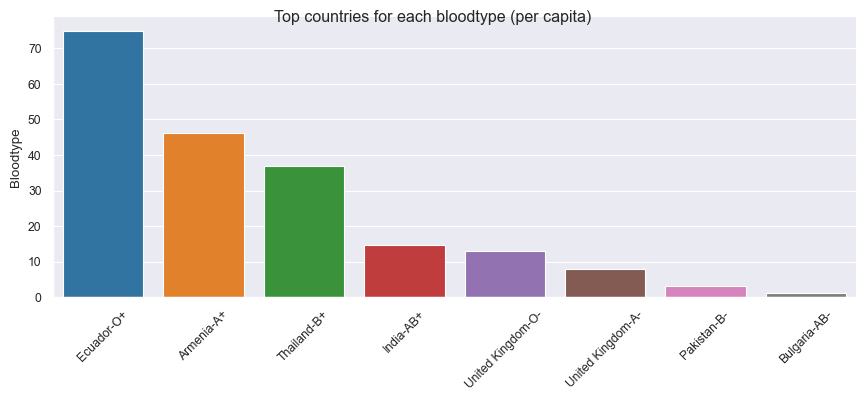

In [117]:
#initialize columns in btype dataframe
btype=pd.DataFrame(country_index.columns[3:11])
btype.columns=['Type']
btype['Country']=np.nan
btype['Proportion']=np.nan
co=[]
prop=[]
#We're going to iteratively sort our dataframe to capture the max proportion of each bloodtype and its country.
#We'll then add those datapoints into the btype dataframe all at once
for i in btype['Type']:
    country_index=country_index.sort_values(i,ascending=False)
    country=country_index.index[0]
#    btype["Country"]=country
#    btype["Proportion"]=country_index.loc[country,i]
    co.append(country)
    prop.append(country_index.loc[country,i])
btype["Country"]=co
btype["Proportion"]=prop

#I'll copy btype and add a descriptive column to use as a label once we graph it
graph=btype
graph["Graph_Label"]=graph["Country"]+"-"+graph["Type"]
print(btype.head())


#Plot the bar graph of graph dataframe!
g=sns.catplot(data=graph, x="Graph_Label", y="Proportion", kind="bar", height=3.5, aspect=2.5)
plt.xticks(rotation=45)
g.set_axis_labels("", "Bloodtype")
g.set_titles("{col_name}")
g.fig.suptitle('Top countries for each bloodtype (per capita)')
#g.set(ylim=(0, 1))
plt.show()

#### Which country has the most universal donors? (O-)

In [68]:
#We're going to answer this question two different ways by giving a line plot both the raw numbers
#and proportions by country for the O- bloodtype.
#From there we'll put them into subplots
O_neg_ranking=complete_df.sort_values('O-', ascending=False)
#We'll only keep the top 10 countries for the proportions, top 5 for the numerical values
O_neg_ranking=O_neg_ranking.iloc[0:10,[0,8,16]]
O_neg_ranking.head(10)

,Country,O-,O-val
112,United Kingdom,13.0,8548945
13,Brazil,9.0,19054437
100,Spain,9.0,4501421
78,New Zealand,9.0,443292
46,Iceland,8.2,28760
51,Ireland,8.0,414125
61,Lebanon,7.7,421160
96,Somalia,7.2,870814
64,Lithuania,7.0,191202
18,Canada,7.0,2638585


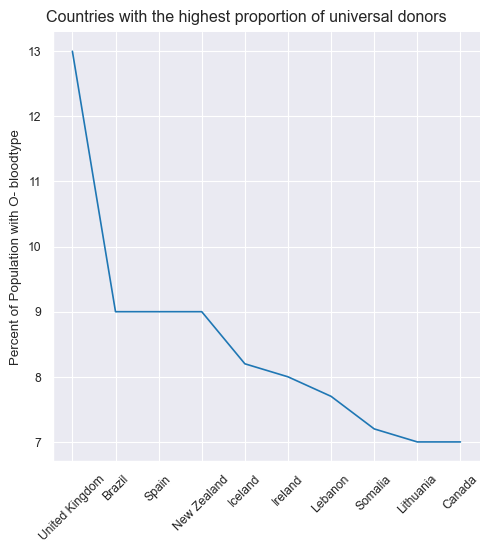

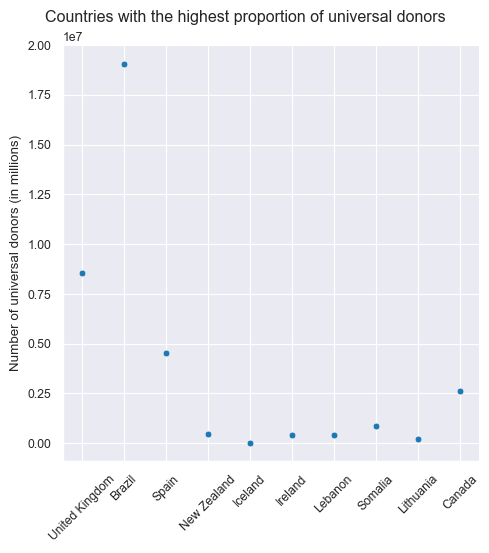

In [69]:
#Now that isolated our universal donor ranking, we can start building graphs
sns.set_style(style="darkgrid")
sns.set_context("paper")

g2=sns.relplot(kind='line', data=O_neg_ranking, x="Country", y="O-")
g2.fig.suptitle('Countries with the highest proportion of universal donors',ha='center', va='center',y=1.)
g2.set_axis_labels("", "Percent of Population with O- bloodtype")
plt.xticks(rotation=45)

g3=sns.relplot(kind='scatter', data=O_neg_ranking, x="Country", y="O-val")
g3.fig.suptitle('Countries with the highest proportion of universal donors',ha='center', va='center',y=1.)
g3.set_axis_labels("", "Number of universal donors (in millions)")

plt.xticks(rotation=45)
plt.show()

#### Which country has the most universal recipients? (AB-) 

In [118]:
#We're going to answer this question two different ways by giving a line plot both the raw numbers
#and proportions by country for the O- bloodtype.
#From there we'll put them into subplots
AB_neg_ranking=complete_df.sort_values('AB-', ascending=False)

#We'll only keep the top 10 countries for the proportions, top 5 for the numerical values
AB_neg_ranking=AB_neg_ranking.iloc[0:10,[0,11,19]]
AB_neg_ranking.head(10)

,Country,AB-,AB-val
94,Slovakia,1.2,65287
9,Belarus,1.2,113302
14,Bulgaria,1.2,83602
71,Moldova,1.1,37009
102,Sweden,1.0,102024
4,Australia,1.0,254664
27,Denmark,1.0,58694
26,Czech Republic,1.0,107024
51,Ireland,1.0,51765
64,Lithuania,1.0,27314


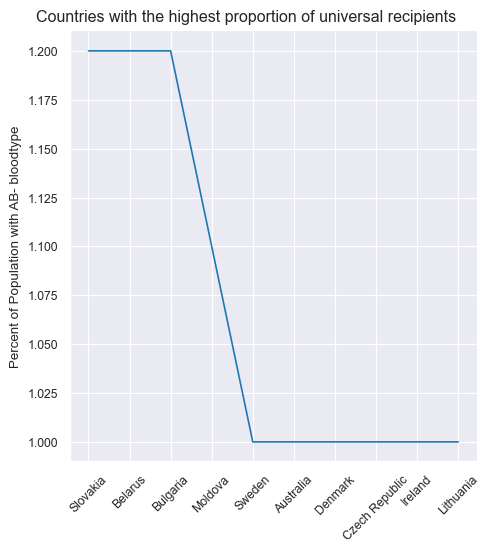

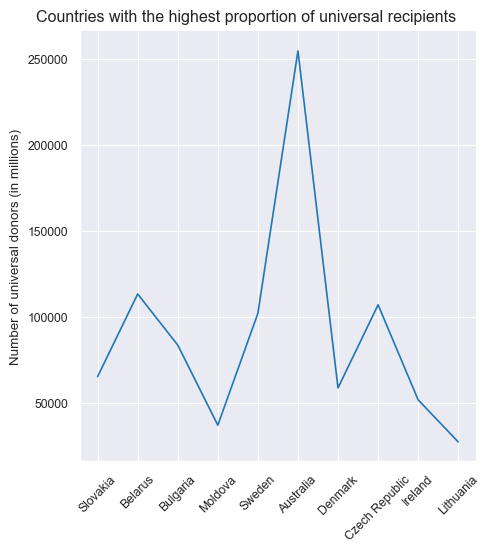

In [119]:
g4=sns.relplot(kind='line', data=AB_neg_ranking, x="Country", y="AB-")
g4.fig.suptitle('Countries with the highest proportion of universal recipients',ha='center', va='center',y=1.)
g4.set_axis_labels("", "Percent of Population with AB- bloodtype")
plt.xticks(rotation=45)

g5=sns.relplot(kind='line', data=AB_neg_ranking, x="Country", y="AB-val")
g5.fig.suptitle('Countries with the highest proportion of universal recipients',ha='center', va='center',y=1.)
g5.set_axis_labels("", "Number of universal donors (in millions)")
plt.xticks(rotation=45)

plt.show()

#### What are the average distributions between bloodtypes by region, and how does it compare to the world averages?

In [120]:
complete_df.tail()
#Here we can see that World in row 117 has Asia for a region, with Western Asia for a sub-region. 
#We'll append it in complete_df and regions_df such that World shows for each of those columns before we move forward. 

complete_df.iloc[117,1]="World"
complete_df.iloc[117,2]="World"
regions_df.iloc[117,1]="World"
regions_df.iloc[117,2]="World"

In [121]:
regions_df=complete_df.iloc[:,0:12]
regions_df=regions_df.drop("Population", axis=1)
regions_df.tail()

,Country,Region,Sub_Region,O+,A+,B+,AB+,O-,A-,B-,AB-
114,Uzbekistan,Asia,Central Asia,29.42,30.93,24.98,9.27,1.68,1.77,1.42,0.53
115,Venezuela,Americas,Latin America and the Caribbean,58.30,28.20,5.60,1.90,3.70,1.80,0.40,0.10
116,Vietnam,Asia,South-eastern Asia,41.70,21.90,30.80,4.98,0.30,0.10,0.20,0.02
117,World,World,World,37.37,27.24,22.83,6.22,2.69,2.09,1.16,0.40
118,Yemen,Africa,Sub-Saharan Africa,47.84,27.50,15.32,2.14,3.66,2.10,1.17,0.16


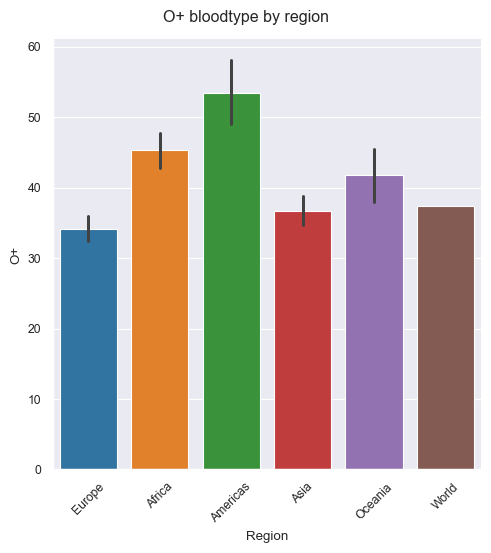

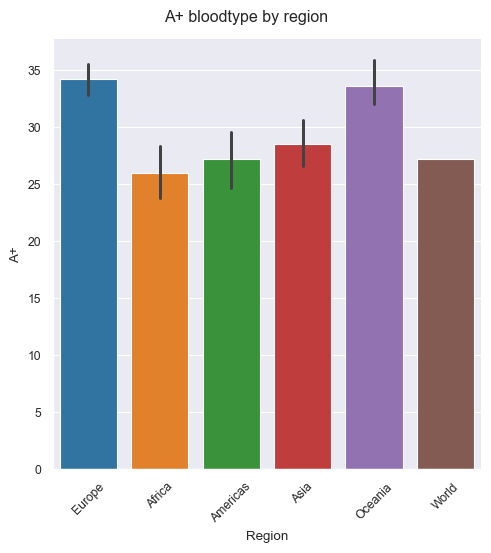

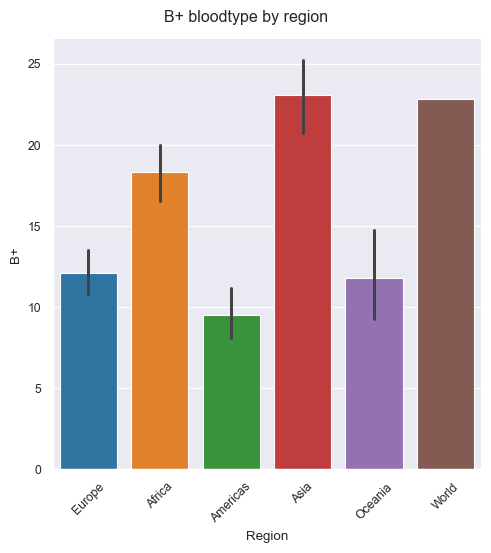

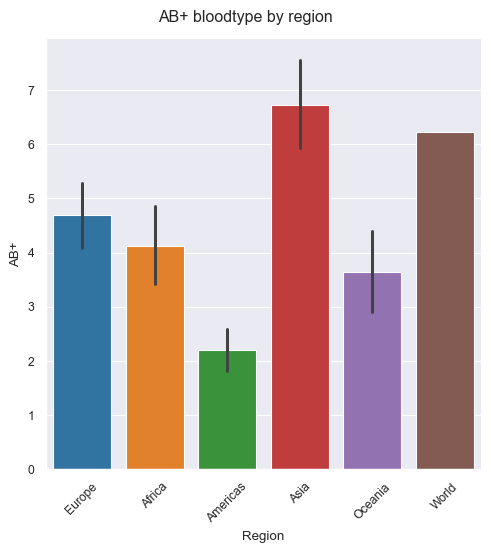

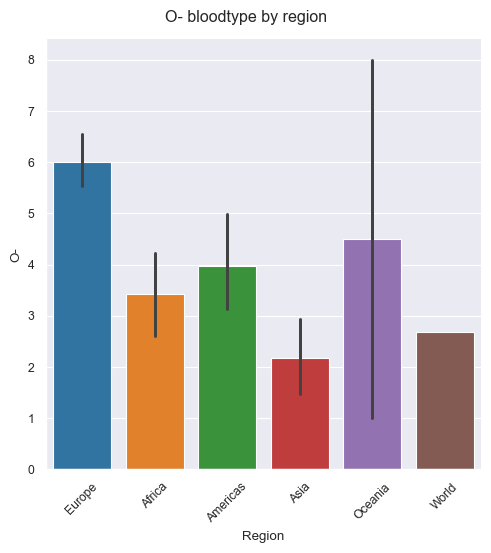

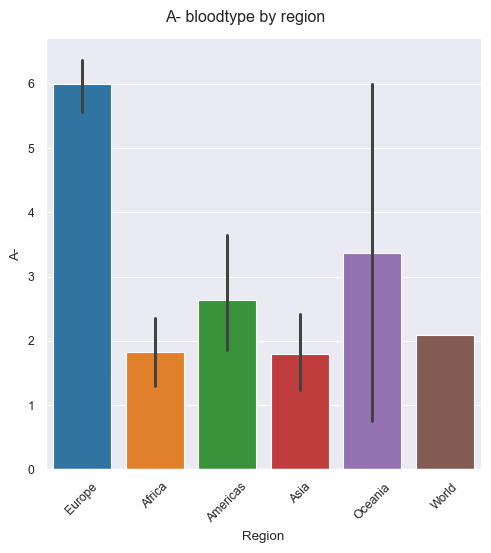

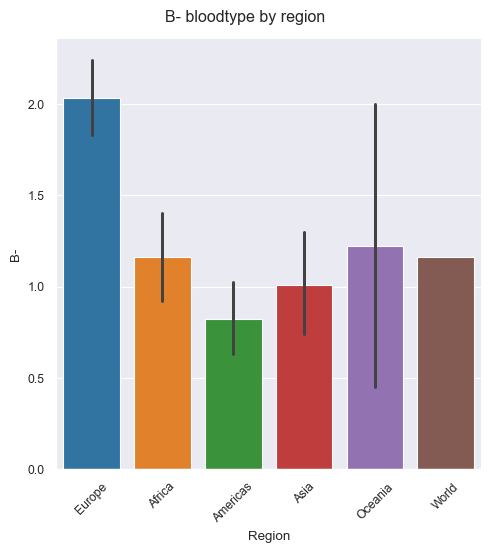

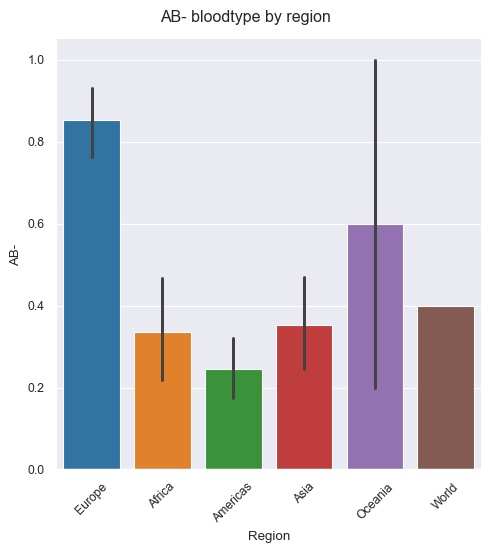

In [122]:
regions_df.tail()
types=['O+','A+','B+','AB+','O-','A-','B-','AB-']
for i in types:
    g6=sns.catplot(data=regions_df,kind='bar',y=i,x='Region')
    plt.xticks(rotation=45)
    title = "{} bloodtype by region"
    g6.fig.suptitle(title.format(i), y=1.03)
    plt.show()


#### What do the bloxplots of the bloodtype distributions look like? 

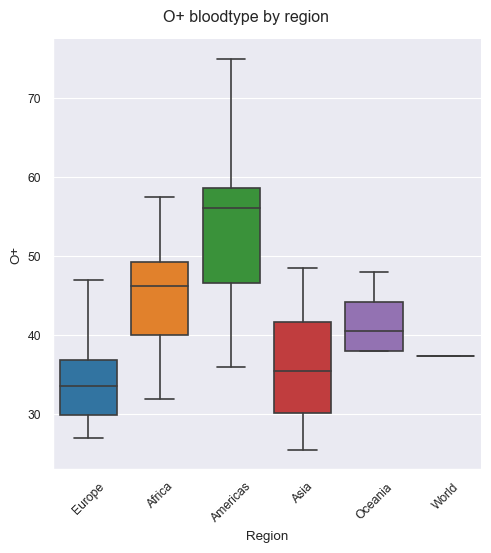

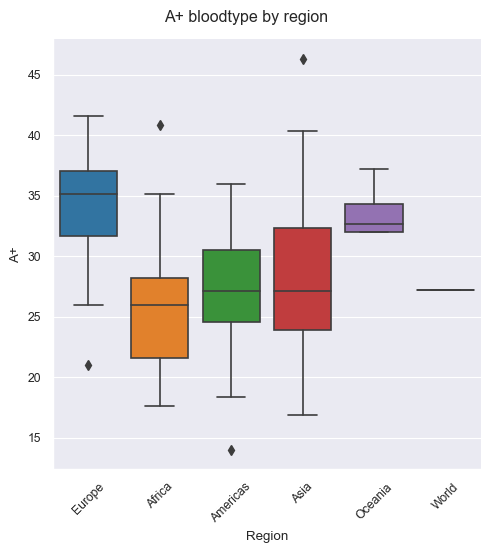

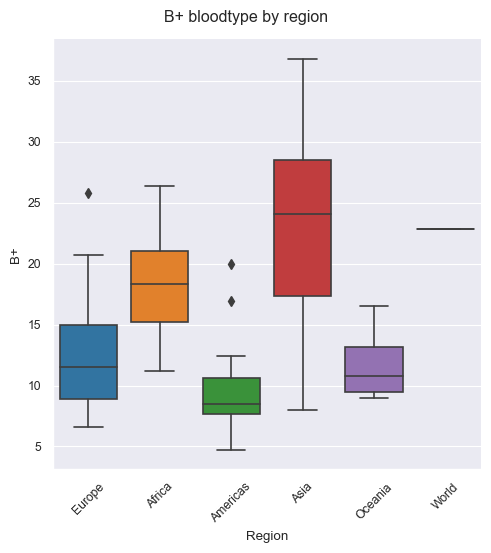

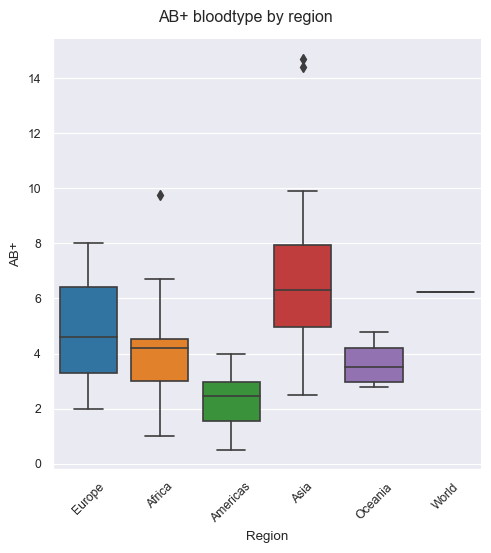

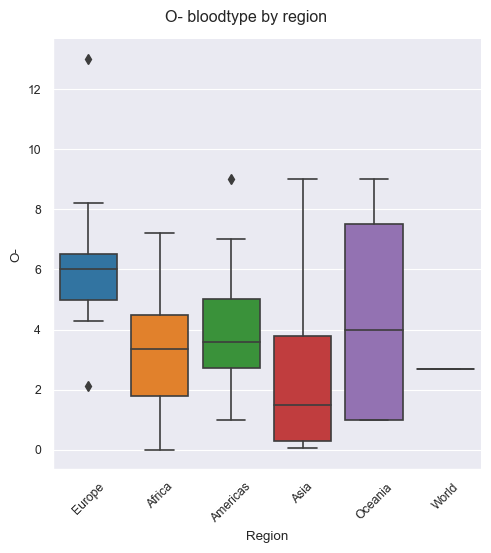

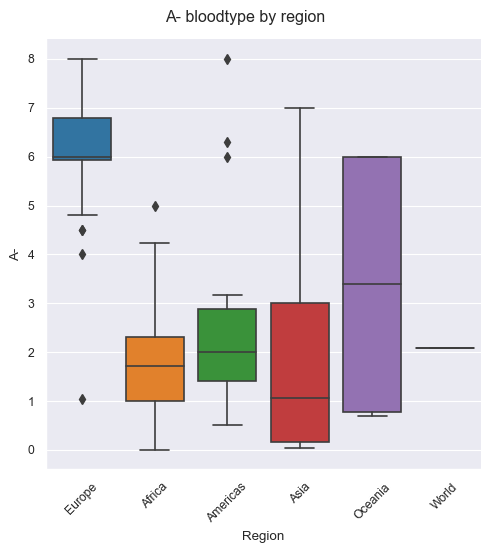

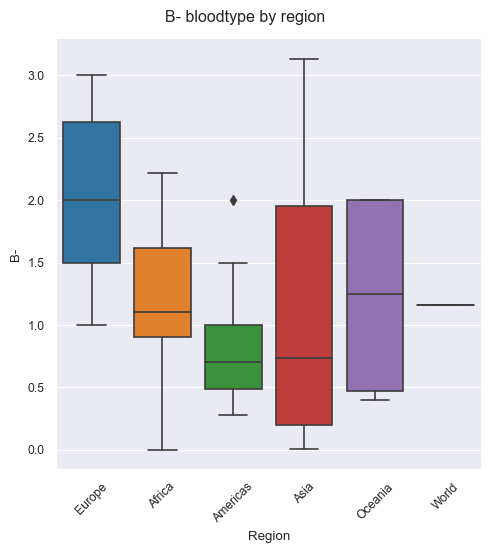

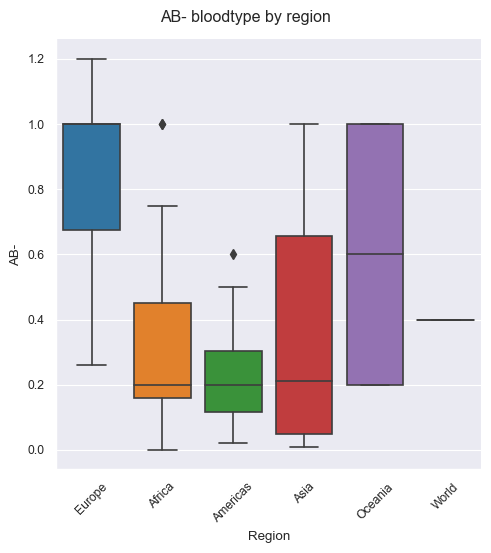

In [123]:
for i in types:
    g7=sns.catplot(data=regions_df,kind='box',y=i,x='Region')
    plt.xticks(rotation=45)
    title = "{} bloodtype by region"
    g7.fig.suptitle(title.format(i), y=1.03)
    plt.show()